In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation

from utils.models import LSTM



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...
loaded 1455 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
removing 6751 not found symbols from the dataset
removing 1505 ambigously positioned symbols from the dataset
selecting genes based on median absolute deviation threshold:  5 ...
0.0
4884.701


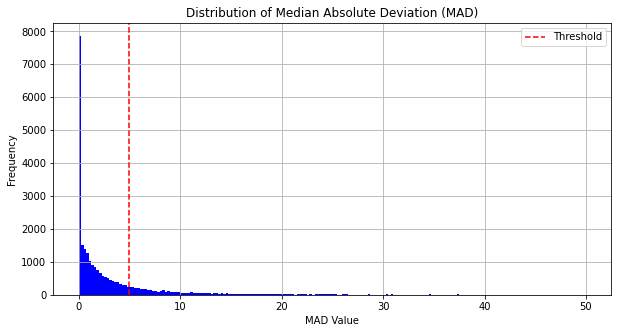

removing 20812 genes under the MAD threshold from the dataset
number of genes selected :  5203
sorting based on genomic position chr then transcript start...
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 1455
converting samples to time series
number of actual individual to be studied : 291


In [2]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

absolute_path = "c:/thesis/data/quant"
metadata_path = "c:/thesis/METADATA_200123.xlsx"

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    #path = absolute_path,
    #metadata_path = metadata_path,
    retain_phases = "Both",
    feature_selection_threshold = 5, 
    batch_size= 32,
    normalization = False,
    transpose=False,
    as_time_series = True,
    MT_removal = True,
    log1p = True,
    min_max=True,
    keep_only_symbols=True,
    drop_ambiguous_pos=True,
    sort_symbols=True)

In [3]:
importlib.reload(LSTM) # to allow modification of the script without restarting the whole session

latent_dim = 32
sequence_length = 5
t_shape = (sequence_length, n_genes)


autoencoder = LSTM.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [4]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=25, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=50)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      early_stopping_callback, 
      tensorboard_callback]

In [5]:
#%tensorboard --logdir ../workfiles/logs/fit

6K so far

In [7]:
hist = autoencoder.fit(x_train, epochs=20, callbacks=cb)

Epoch 1/20
10/10 [==============================] - 3s 272ms/step - loss: 0.1997 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 2s 227ms/step - loss: 0.1984 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 2s 190ms/step - loss: 0.1981 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 2s 204ms/step - loss: 0.1980 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 2s 180ms/step - loss: 0.1980 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 2s 191ms/step - loss: 0.1979 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 2s 224ms/step - loss: 0.1978 - lr: 0.0010
Epoch 8/20
10/10 [==============================] - 2s 184ms/step - loss: 0.1978 - lr: 0.0010
Epoch 9/20
10/10 [==============================] - 2s 188ms/step - loss: 0.1978 - lr: 0.0010
Epoch 10/20
10/10 [==============================] - 2s 176ms/step - loss: 0.1978 - lr: 0.0010
Epoch 11/20
10/10 [==============================] - 2s 176

In [8]:
autoencoder.load_weights(checkpoint_filepath)


[0.19983145594596863, 0.19897855818271637, 0.19871753454208374, 0.19861061871051788, 0.19855350255966187, 0.19848783314228058, 0.19843915104866028, 0.198425754904747, 0.19840815663337708, 0.19834774732589722, 0.19833895564079285, 0.19833683967590332, 0.19833509624004364, 0.19833429157733917, 0.19833338260650635, 0.19833290576934814, 0.1983325183391571, 0.1983322948217392, 0.19833223521709442, 0.19828802347183228]


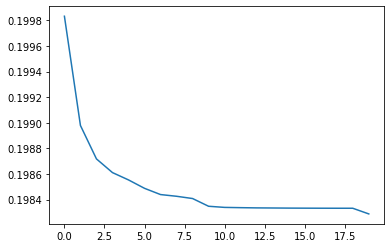

In [9]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])




benchmarking model : LSTM_non_transpose
number of parametters of the model: 11617536
shape of the dataset: (291, 5, 5203)
the dataset meets the min_max requirement
loss: 0.19825532
adding new performer to the history


,model_name,param_count,loss,obs_count,gene_number
0,FC_autoencoder,13522496,0.002833,NaN,NaN
1,FC_autoencoder,13522496,0.002833,NaN,NaN
2,FC_autoencoder,13522496,0.002833,NaN,NaN
3,FC_autoencoder,13522496,0.002826,NaN,NaN
4,FC_autoencoder,13522496,0.002810,NaN,NaN
5,FC_autoencoder,13522496,0.002810,NaN,NaN
6,FC_autoencoder,13522496,0.002810,NaN,NaN
7,FC_autoencoder,13522496,0.002810,5953.0,5953.0
8,FC_autoencoder,13522496,0.002810,2853.0,5953.0
9,FC_autoencoder,13522496,0.008133,2853.0,5953.0


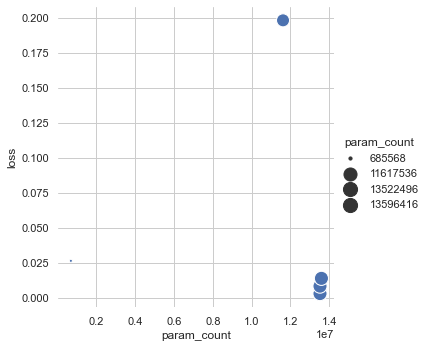

In [11]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train)

### some diagnosis

In [22]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

# Trouble shooting 

In [15]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
decoded = autoencoder.decoder(z)

In [16]:
e_ = e[0]  
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0]  



In [17]:
# Counting how many entries has been 0'd out

indexes_original = (sum(e_) == 0).numpy()
indexes_reconstructed = (sum(decoded_) == 0).numpy()

print("sum of series being null in the original patient data:",sum(indexes_original))
print("sum of series being null in the reconstructed patient data:",sum(indexes_reconstructed))
print("number of total genes",len(e_[0]))

print("this represent", (sum(indexes_reconstructed)/len(e_[0]))*100,"% of 0'd out indexes" )

sum of series being null in the original patient data: 0
sum of series being null in the reconstructed patient data: 2446
number of total genes 5203
this represent 47.011339611762445 % of 0'd out indexes


In [18]:
print("sum of total experession on orginal data:", sum(sum(e_)))
print("sum of total experession on reconstructed data:", sum(sum(decoded_)))

sum of total experession on orginal data: tf.Tensor(16554.531, shape=(), dtype=float32)
sum of total experession on reconstructed data: tf.Tensor(8450.535, shape=(), dtype=float32)


On a given run, this represents a 30% delta

In [19]:
indexes = (sum(decoded_) != 0).numpy()

In [20]:
# let's see if the 0'd out entries are creating a bias
print(sum(sum(e_[0:5, indexes])))
print(sum(sum(decoded_[0:5, indexes])))

tf.Tensor(8744.1045, shape=(), dtype=float32)
tf.Tensor(8450.535, shape=(), dtype=float32)


In [ ]:
autoencoder.encoder.save('../workfiles/LSTM')


In [14]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

1/5 [=====>........................] - ETA: 1s

2023-08-25 11:35:48.355153: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 0s 27ms/step


# Can we have some visualisation over the entire dataset ?

10/10 [==============================] - 0s 5ms/step


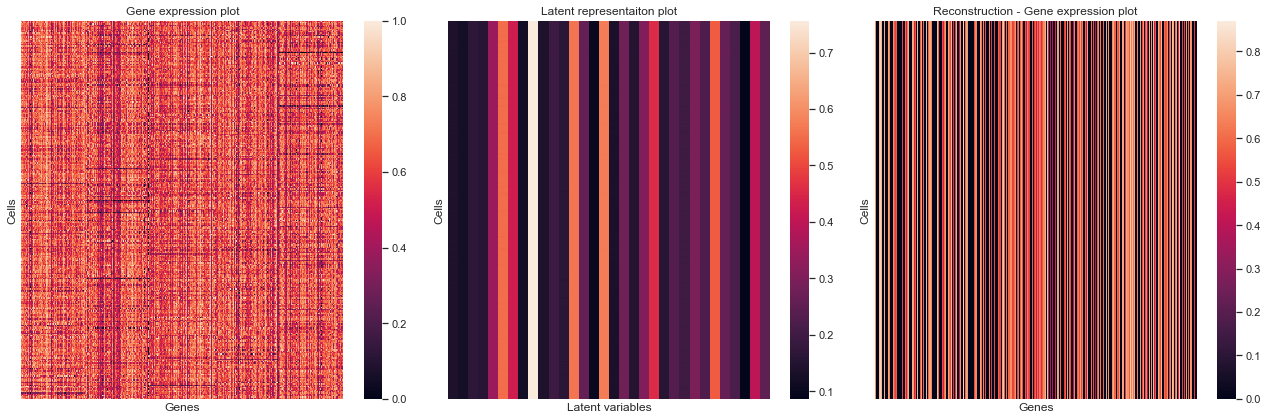

In [21]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)

In [ ]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [ ]:
df.to_csv("../workfiles/processed_data_lstm.csv", index=False)
